# AlexNet

# LIBRARIES

In [2]:
import os, sys
import tensorflow as tf
from keras import losses
from keras.utils import image_dataset_from_directory
from keras.models import Sequential
from keras.regularizers import L2
from keras.layers import Input, Conv2D,Flatten, Dense, Activation, MaxPool2D, BatchNormalization, Dropout, Rescaling
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import SGD
import numpy as np
import matplotlib.pyplot as plt

2022-11-01 22:20:37.475402: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-01 22:20:37.587200: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-01 22:20:38.105187: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.8/lib64
2022-11-01 22:20:38.105235: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: can

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass

# DATASET

In [4]:
BATCH_SIZE = 128
WIDTH = 227
HEIGHT = 227
CHANNELS = 3
PATH_DATASET_TRAIN = '/mnt/files/Datasets/cats-dogs/training_set/'
PATH_DATASET_TEST = '/mnt/files/Datasets/cats-dogs/test_set/'

## train dataset

In [5]:
train_ds = image_dataset_from_directory(directory=PATH_DATASET_TRAIN,
                                        seed=123,
                                        image_size=(WIDTH, HEIGHT),
                                        color_mode='rgb',
                                        batch_size=BATCH_SIZE)

Found 8000 files belonging to 2 classes.


2022-11-01 22:20:39.209747: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-01 22:20:39.561936: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9687 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


## validation/test dataset

In [6]:
test_ds = image_dataset_from_directory(directory=PATH_DATASET_TEST,
                                       seed=123,
                                       image_size=(WIDTH, HEIGHT),
                                       color_mode='rgb',
                                       batch_size=BATCH_SIZE)

Found 2000 files belonging to 2 classes.


In [7]:
class_names = train_ds.class_names
print(class_names)

['cats', 'dogs']


## Visualization some examples

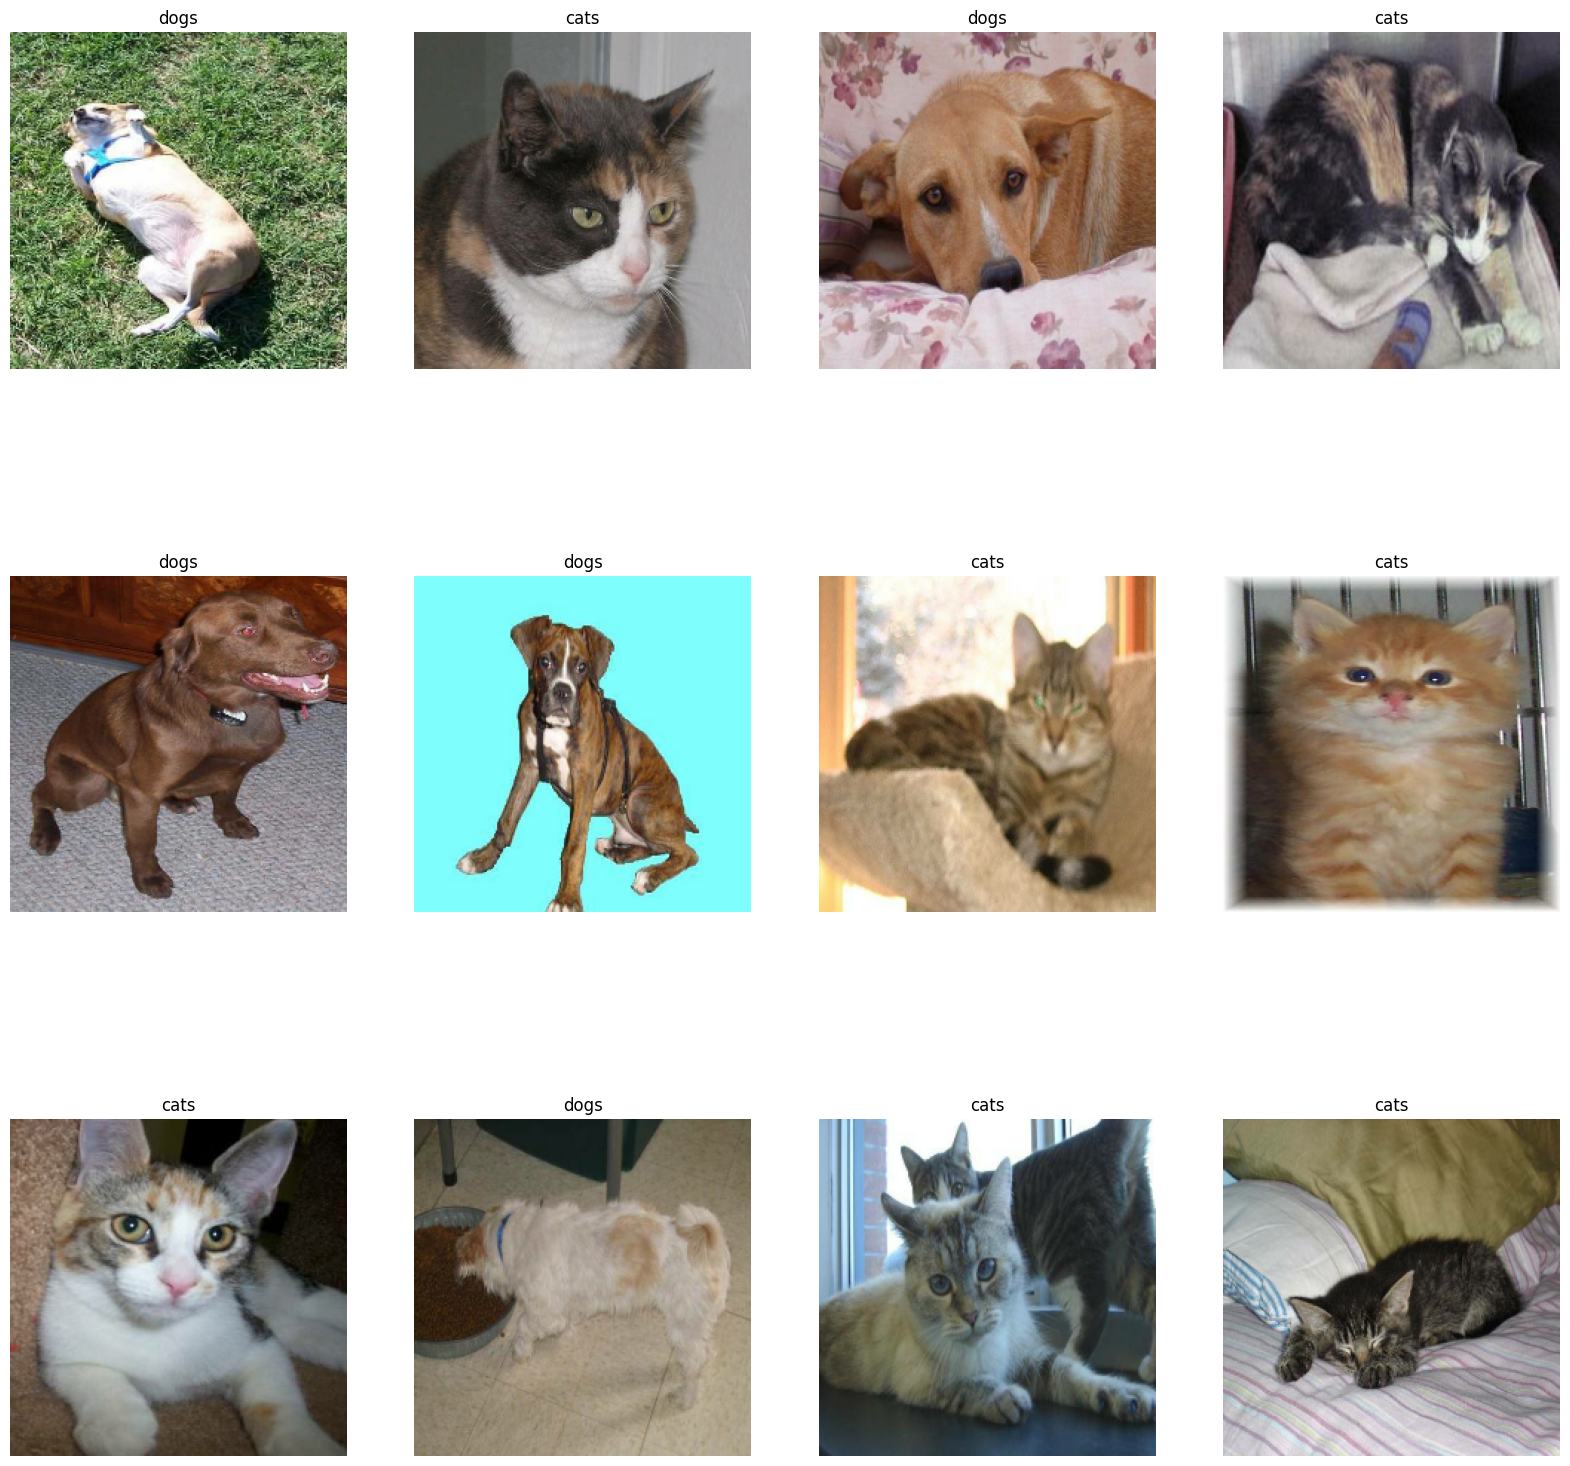

In [8]:
plt.figure(figsize=(20, 20))

for images, labels in train_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

## Configure the dataset for performance

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# MODEL

In [10]:
model = Sequential()

# 1st block (Conv + pool + batchnorm)
model.add(Input(shape=(227, 227, 3)))
model.add(Rescaling(scale=1./255))
model.add(Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), padding='valid'))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(3, 3), strides=(2, 2)))
model.add(BatchNormalization())

# 2st block (Conv + pool + batchnorm)
model.add(Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), padding='same', kernel_regularizer=L2(0.0005)))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='valid'))
model.add(BatchNormalization())

# 3nd block (Conv + batchnorm)
model.add(Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=L2(0.0005)))
model.add(Activation('relu'))
model.add(BatchNormalization())

# 4nd block (Conv + batchnorm)
model.add(Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=L2(0.0005)))
model.add(Activation('relu'))
model.add(BatchNormalization())

# 5nd block (Conv + batchnorm)
model.add(Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=L2(0.0005)))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='valid'))
model.add(BatchNormalization())
          
# Flatten
model.add(Flatten())

# FC1
model.add(Dense(units=256, activation='relu'))
model.add(Dropout(0.5))

# FC2
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.5))

# Softmax
model.add(Dense(units=len(class_names), activation='softmax'))

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 227, 227, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 55, 55, 96)        34944     
                                                                 
 activation (Activation)     (None, 55, 55, 96)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 27, 27, 96)       384       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 256)       6

# CALLBACKS

In [12]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1))

checkpoint_filepath = '/tmp/checkpoint/model-{epoch:03d}-{val_accuracy:03f}.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

callbacks = [reduce_lr, model_checkpoint_callback]

# OPTIMIZER

In [13]:
optimizer = SGD(learning_rate=0.01, momentum=0.9)
loss = losses.SparseCategoricalCrossentropy(from_logits=False)

# COMPILE

In [14]:
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

# TRAINING

In [15]:
EPOCHS = 90
history = model.fit(train_ds, 
                    validation_data=test_ds, 
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    callbacks=callbacks, verbose=2)

Epoch 1/90


2022-11-01 22:20:42.972699: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8600
2022-11-01 22:20:44.143344: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


63/63 - 19s - loss: 1.4056 - accuracy: 0.5370 - val_loss: 1.3106 - val_accuracy: 0.4880 - lr: 0.0100 - 19s/epoch - 298ms/step
Epoch 2/90
63/63 - 7s - loss: 1.2650 - accuracy: 0.5775 - val_loss: 1.2624 - val_accuracy: 0.5595 - lr: 0.0100 - 7s/epoch - 112ms/step
Epoch 3/90
63/63 - 7s - loss: 1.2270 - accuracy: 0.6202 - val_loss: 1.2171 - val_accuracy: 0.6385 - lr: 0.0100 - 7s/epoch - 116ms/step
Epoch 4/90
63/63 - 7s - loss: 1.1956 - accuracy: 0.6575 - val_loss: 1.1896 - val_accuracy: 0.6700 - lr: 0.0100 - 7s/epoch - 113ms/step
Epoch 5/90
63/63 - 7s - loss: 1.1671 - accuracy: 0.6791 - val_loss: 1.2012 - val_accuracy: 0.6235 - lr: 0.0100 - 7s/epoch - 114ms/step
Epoch 6/90
63/63 - 7s - loss: 1.1368 - accuracy: 0.6960 - val_loss: 1.1886 - val_accuracy: 0.6280 - lr: 0.0100 - 7s/epoch - 116ms/step
Epoch 7/90
63/63 - 7s - loss: 1.1064 - accuracy: 0.7092 - val_loss: 1.2511 - val_accuracy: 0.6220 - lr: 0.0100 - 7s/epoch - 112ms/step
Epoch 8/90
63/63 - 7s - loss: 1.0718 - accuracy: 0.7390 - val_lo

# EVALUATING

In [18]:
model.load_weights('/tmp/checkpoint/model-059-0.870500.h5')  # Loading the best modelS

In [19]:
model.evaluate(test_ds)

16/16 [==============================] - 1s 38ms/step - loss: 1.4170 - accuracy: 0.8705


[1.4169903993606567, 0.8705000281333923]

## Curves

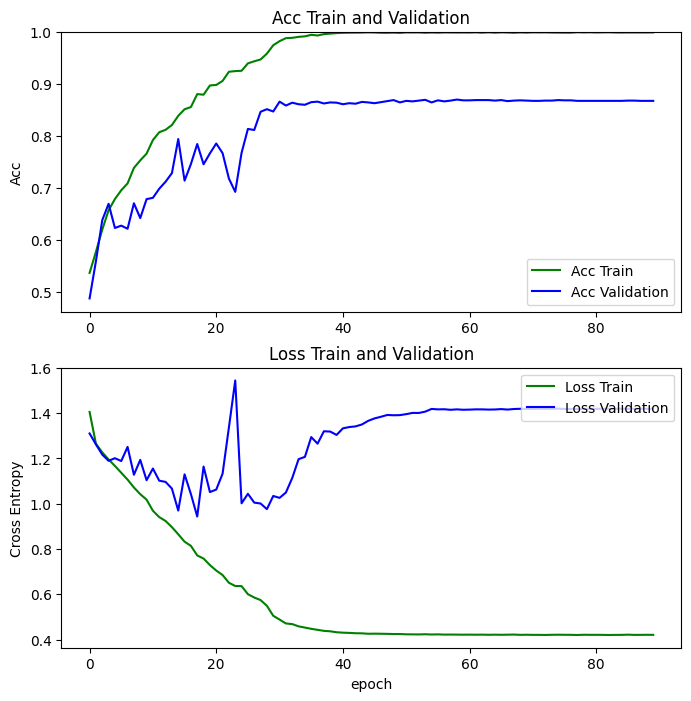

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, 'g', label='Acc Train')
plt.plot(val_acc, 'b', label='Acc Validation')
plt.legend(loc='lower right')
plt.ylabel('Acc')
plt.ylim([min(plt.ylim()),1.001])
plt.title('Acc Train and Validation')

plt.subplot(2, 1, 2)
plt.plot(loss, 'g', label='Loss Train')
plt.plot(val_loss, 'b', label='Loss Validation')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Loss Train and Validation')
plt.xlabel('epoch')
plt.show()

## Infering some examples (green = correct, red = wrong)

4/4 [==============================] - 0s 9ms/step


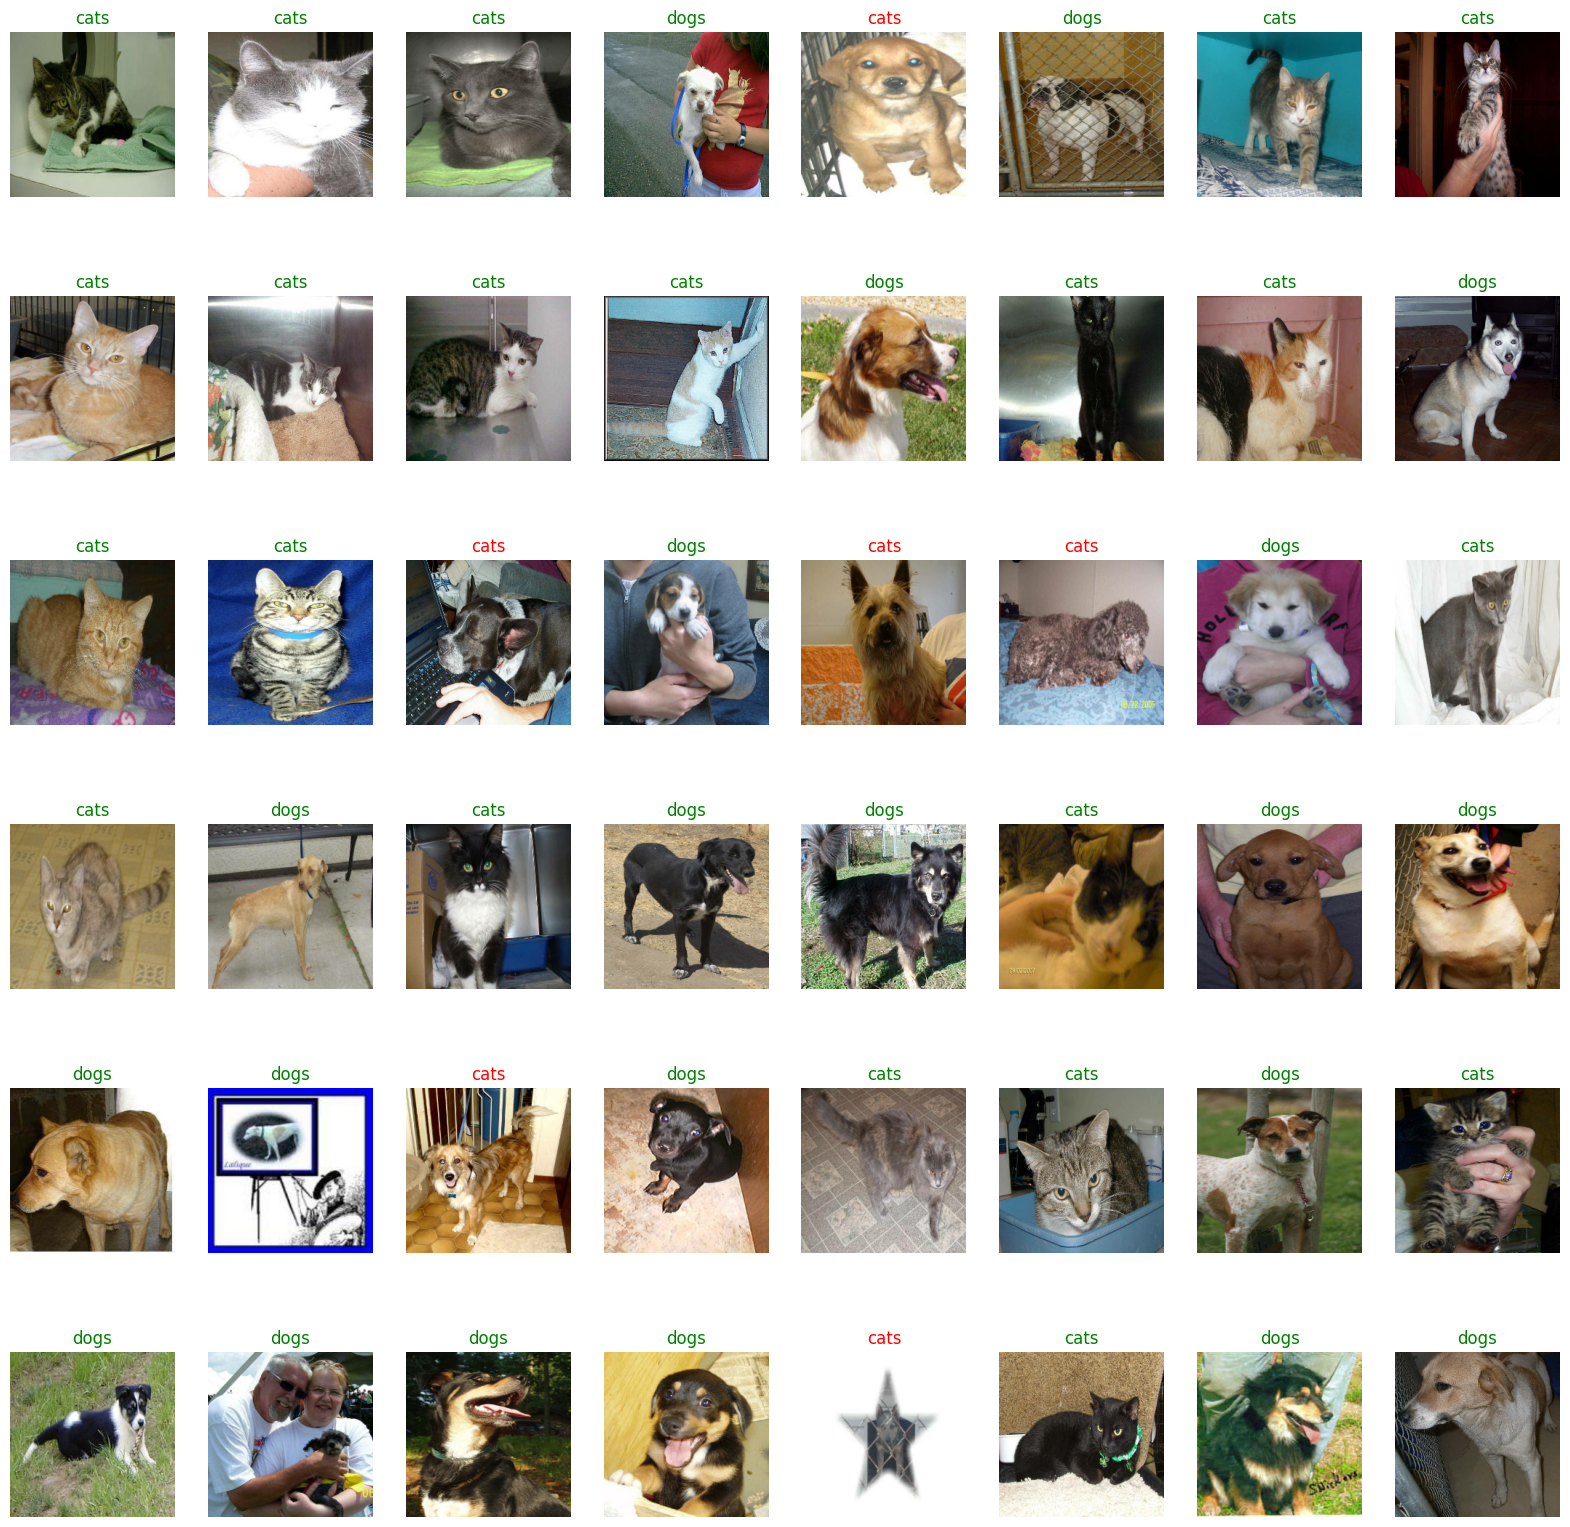

In [21]:
plt.figure(figsize=(20, 20))
for images, labels in test_ds.take(1):
    preds_classes = np.argmax(model.predict(images), axis=1)
    for i in range(48):
        ax = plt.subplot(6, 8, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        if preds_classes[i] == labels[i]:
            plt.title(class_names[preds_classes[i]], color='g')
        else:
            plt.title(class_names[preds_classes[i]], color='r')
        plt.axis('off')